### **Check GPU**
To effectively use mixed precision training, it is essential to have GPUs with a higher compute capability. In Colab, the T4 GPU has a compute capability of 7.5. If we're using our own hardware, our GPU needs a score of 7.0+

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ab98ab68-b5b0-5ba8-4b58-9f7aa896dfbe)


In [ ]:
!pip install wandb

In [2]:
import itertools
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import load_model
import wandb
from wandb.integration.keras import WandbMetricsLogger
from sklearn.metrics import confusion_matrix
import seaborn as sns
import plotly.express as px

### **Helper Functions**

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

### **TensorFlow Food 101 Dataset**

In [ ]:
dataset_lists = tfds.list_builders()

print(f"Total datasets available: {len(dataset_lists)}")

is_food101_available = "food101" in dataset_lists

if is_food101_available:
    print("✅ 'food101' dataset is available in TensorFlow Datasets.")
else:
    print("❌ 'food101' dataset is NOT available in TensorFlow Datasets.")

Total datasets available: 1296
✅ 'food101' dataset is available in TensorFlow Datasets.


In [3]:
print("Loading 'food101' dataset...")
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Loading 'food101' dataset...


**Labels are not one hot encoded**

In [56]:
for image, label in train_data.take(5):
    print("Label:", label.numpy())

Label: 29
Label: 9
Label: 41
Label: 3
Label: 57


In [5]:
print("\n✅ Dataset successfully loaded!")
print(f"Dataset name: {ds_info.name}")
print(f"Total training samples: {ds_info.splits['train'].num_examples}")
print(f"Total validation samples: {ds_info.splits['validation'].num_examples}")
print(f"Number of classes: {ds_info.features['label'].num_classes}")

print("\nDataset Features:")
print(ds_info.features)


✅ Dataset successfully loaded!
Dataset name: food101
Total training samples: 75750
Total validation samples: 25250
Number of classes: 101

Dataset Features:
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})


In [6]:
class_names = ds_info.features["label"].names
print(f"Total number of classes: {len(class_names)}")

print("First 10 class names:")
print(class_names[:10])

Total number of classes: 101
First 10 class names:
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [ ]:
train_one_sample = train_data.take(1)

print("✅ Extracted one sample from the training dataset.")

for image, label in train_one_sample:
    print(f"Image shape: {image.shape}")
    print(f"Image Dtype: {image.dtype}")
    print(f"Label: {label.numpy()} ({class_names[label.numpy()]})")
    break

✅ Extracted one sample from the training dataset.
Image shape: (512, 512, 3)
Image Dtype: <dtype: 'uint8'>
Label: 16 (cheesecake)


In [ ]:
min_pixel = tf.reduce_min(image)
max_pixel = tf.reduce_max(image)

print(f"Minimum pixel value: {min_pixel.numpy()}")
print(f"Maximum pixel value: {max_pixel.numpy()}")

Minimum pixel value: 0
Maximum pixel value: 255


In [ ]:
num_classes = len(class_names)
random_classes = random.sample(range(num_classes), 5)

fig, axes = plt.subplots(5, 5, figsize=(12, 12))

for row, class_idx in enumerate(random_classes):
    # Filter dataset to get images of the selected class
    class_images = train_data.filter(lambda img, lbl: lbl == class_idx).take(5)

    for col, (image, label) in enumerate(class_images):
        axes[row, col].imshow(image.numpy().astype("uint8"))
        axes[row, col].axis("off")

        # Add label only on the first image of each row
        if col == 0:
            axes[row, col].set_title(class_names[class_idx], fontsize=10)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### **Preprocessing Functions**

In [8]:
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape])
# image = image/255. # Not required with EfficientNetBX Models from tf.keras.applications
  return tf.cast(image, tf.float32), label

def preprocess_and_augment(image, label):
    # Ensure image has 3 channels (RGB)
    if image.shape[-1] != 3:
        image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB if necessary

    image = tf.image.resize(image, (224, 224))
    image = image / 255.0

    # Apply augmentation
    image = tf.image.random_flip_left_right(image)  # Horizontal flip
    image = tf.image.random_flip_up_down(image)    # Vertical flip
    image = tf.image.random_contrast(image, lower=0.2, upper=0.8)  # Random contrast

    return image, label

In [ ]:
preprocessed_image = preprocess_img(image, label)[0]
print(f"Image Before Preprocessing:\n{image[:2]}..., \nImage Shape: {image.shape}\nImage Data: {image.dtype}\n")
print(f"Image After Preprocessing:\n{preprocessed_image[:2]}\nImage Shape:{preprocessed_image.shape}\nImage Data:{preprocessed_image.dtype}\n")

Image Before Preprocessing:
[[[57 50 34]
  [63 56 40]
  [67 60 44]
  ...
  [16 16  8]
  [15 15  7]
  [15 15  7]]

 [[58 51 35]
  [62 55 39]
  [65 58 42]
  ...
  [17 17  9]
  [16 16  8]
  [16 16  8]]]..., 
Image Shape: (512, 512, 3)
Image Data: <dtype: 'uint8'>

Image After Preprocessing:
[[[60.67347  53.67347  37.67347 ]
  [64.122444 57.122448 41.122448]
  [62.071426 55.071426 39.071426]
  ...
  [16.28062  16.28062   8.28062 ]
  [16.974485 16.974485  8.974485]
  [15.642858 15.642858  7.642857]]

 [[61.280613 53.280613 40.280613]
  [61.938774 53.938774 40.938774]
  [66.77041  58.77041  45.77041 ]
  ...
  [16.       16.        8.      ]
  [16.071442 16.071442  8.071442]
  [18.331665 18.331665 10.331665]]]
Image Shape:(224, 224, 3)
Image Data:<dtype: 'float32'>



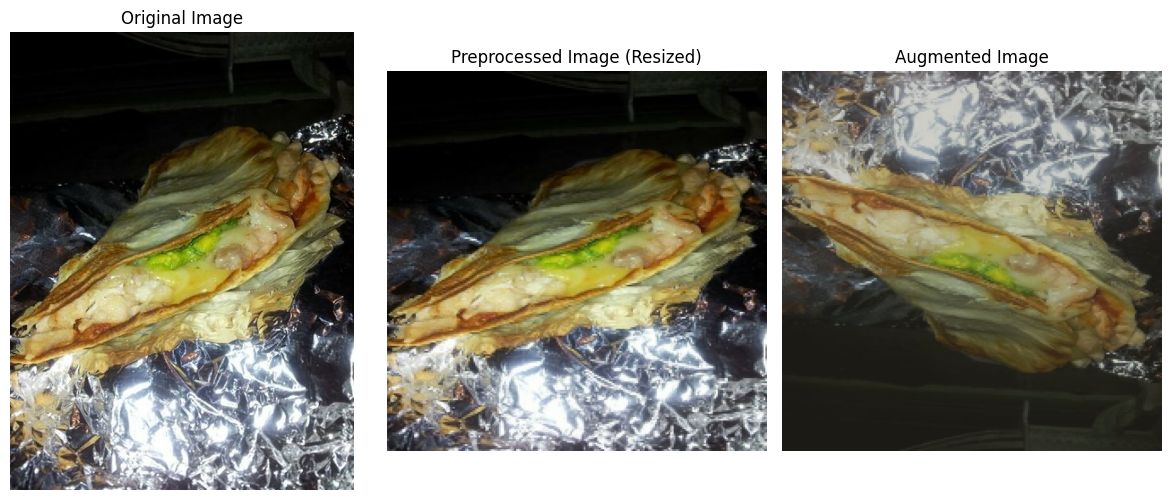

In [ ]:
sample_image, sample_label = next(iter(train_data.take(1)))

preprocessed_image = preprocess_img(sample_image, sample_label)[0]
augmented_image = preprocess_and_augment(sample_image, sample_label)[0]

# Convert tensors to numpy for visualization
sample_image_np = sample_image.numpy().astype("uint8")
preprocessed_image_np = preprocessed_image.numpy().astype("uint8")
augmented_image_np = (augmented_image.numpy() * 255).astype("uint8")  # Scale back for display

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

axes[0].imshow(sample_image_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(preprocessed_image_np)
axes[1].set_title("Preprocessed Image (Resized)")
axes[1].axis("off")

axes[2].imshow(augmented_image_np)
axes[2].set_title("Augmented Image")
axes[2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Randomly flip images horizontally
    tf.keras.layers.RandomRotation(0.2),      # Randomly rotate images
    tf.keras.layers.RandomZoom(0.2),          # Randomly zoom images
    tf.keras.layers.RandomBrightness(0.2),    # Adjust brightness randomly
])

In [9]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data and turn it into batches
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
print("Training Data Pipeline Configured:")
print(f"- Batch Size: {32}")
print(f"- Shuffling Buffer: {1000}")
print(f"- Prefetching Enabled: {tf.data.AUTOTUNE}\n")

print("Test Data Pipeline Configured:")
print(f"- Batch Size: {32}")
print(f"- Prefetching Enabled: {tf.data.AUTOTUNE}\n")

train_batch = next(iter(train_data))
test_batch = next(iter(test_data))

print(f"First Training Batch:")
print(f"- Image Batch Shape: {train_batch[0].shape}")
print(f"- Label Batch Shape: {train_batch[1].shape}\n")

print(f"First Test Batch:")
print(f"- Image Batch Shape: {test_batch[0].shape}")
print(f"- Label Batch Shape: {test_batch[1].shape}")

Training Data Pipeline Configured:
- Batch Size: 32
- Shuffling Buffer: 1000
- Prefetching Enabled: -1

Test Data Pipeline Configured:
- Batch Size: 32
- Prefetching Enabled: -1

First Training Batch:
- Image Batch Shape: (32, 224, 224, 3)
- Label Batch Shape: (32,)

First Test Batch:
- Image Batch Shape: (32, 224, 224, 3)
- Label Batch Shape: (32,)


### **Callbacks**

In [ ]:
checkpoint_path = "model_checkpoints/efficientnet.weights.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                               save_weights_only=True,
                                                               monitor="val_accuracy",
                                                               save_best_only=True,
                                                               verbose=0)

### **Mixed Precision Training**
Mixed precision utilizes a combination of float32 and float16 datatypes to speedup the model performance

In [ ]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [ ]:
print(f"Current Mixed Precision Policy: {mixed_precision.global_policy()}")

Current Mixed Precision Policy: <DTypePolicy "mixed_float16">


In [ ]:
wandb.init(
    project="Food Vision 101",
    name="EfficientNetB4_baseline",
    group="Transfer Learning Experiments",
    notes="Baseline model with EfficientNetB4, Food101 dataset, frozen base model.",
    tags=["EfficientNetB4", "baseline", "food-classification"],

    config={
        # Model Parameters
        "architecture": "EfficientNetB4",
        "input_shape": (224, 224, 3),
        "num_classes": 101,  # Food101 dataset has 101 classes

        # Training Parameters
        "epochs": 5,
        "batch_size": 32,
        "learning_rate": 0.001,
        "optimizer": "Adam",
        "loss_function": "sparse_categorical_crossentropy",
        "metrics": ["accuracy"],

        # Dataset Details
        "dataset": "TensorFlow Food101",
        "train_size": len(train_data),
        "val_size": len(test_data),
        "validation_split": 0.15,

        # Model Checkpointing
        "checkpoint_monitor": "val_accuracy",
        "checkpoint_mode": "max",
        "save_best_only": True,

        # Experiment Tracking
        "run_type": "baseline",
        "experiment_notes": "Testing EfficientNetB4 on Food101 dataset with default settings.",
    }
)

<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hamzaazharmuhammad (mhamza007) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
# x = preprocessing.Rescaling(1./255)(x) #EfficientNetBX models have scaling built-in, for other models we can add this layer
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 7, 7, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         181,093 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_2 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,854,916 (68.11 MB)

 Trainable params: 181,093 (707.39 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [ ]:
for layer in model.layers:
    print(f"Layer Name: {layer.name}")
    print(f"Trainable: {layer.trainable}")
    print(f"Data Type: {layer.dtype}")
    print(f"Data Type Policy: {layer.dtype_policy}")
    print("-" * 30)

Layer Name: input_layer
Trainable: True
Data Type: float32
Data Type Policy: <DTypePolicy "mixed_float16">
------------------------------
Layer Name: efficientnetb4
Trainable: False
Data Type: float32
Data Type Policy: <DTypePolicy "mixed_float16">
------------------------------
Layer Name: global_average_pooling_layer
Trainable: True
Data Type: float32
Data Type Policy: <DTypePolicy "mixed_float16">
------------------------------
Layer Name: dense
Trainable: True
Data Type: float32
Data Type Policy: <DTypePolicy "mixed_float16">
------------------------------
Layer Name: softmax_float32
Trainable: True
Data Type: float32
Data Type Policy: <DTypePolicy "float32">
------------------------------


In [ ]:
for layer in model.layers[1].layers[-5:]:
    print(f"Layer Name: {layer.name}, Trainable: {layer.trainable}, Data Type: {layer.dtype}, Data Type Policy: {layer.dtype_policy}\n")

Layer Name: block7b_drop, Trainable: False, Data Type: float32, Data Type Policy: <DTypePolicy "mixed_float16">

Layer Name: block7b_add, Trainable: False, Data Type: float32, Data Type Policy: <DTypePolicy "mixed_float16">

Layer Name: top_conv, Trainable: False, Data Type: float32, Data Type Policy: <DTypePolicy "mixed_float16">

Layer Name: top_bn, Trainable: False, Data Type: float32, Data Type Policy: <DTypePolicy "mixed_float16">

Layer Name: top_activation, Trainable: False, Data Type: float32, Data Type Policy: <DTypePolicy "mixed_float16">



### **Feature Extraction**

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

history_food101_feature_extract = model.fit(train_data,
                                                epochs=5,
                                                validation_data=test_data,
                                                validation_steps=int(0.15 * len(test_data)),
                                                callbacks=[model_checkpoint_callback, WandbMetricsLogger()])

wandb.finish()

Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 270s 92ms/step - accuracy: 0.4580 - loss: 2.3199 - val_accuracy: 0.6637 - val_loss: 1.2505
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 253s 100ms/step - accuracy: 0.6353 - loss: 1.4098 - val_accuracy: 0.6822 - val_loss: 1.1832
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 202s 84ms/step - accuracy: 0.6674 - loss: 1.2684 - val_accuracy: 0.6962 - val_loss: 1.1322
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 178s 74ms/step - accuracy: 0.6903 - loss: 1.1703 - val_accuracy: 0.7018 - val_loss: 1.1054
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 200s 84ms/step - accuracy: 0.7044 - loss: 1.1088 - val_accuracy: 0.7029 - val_loss: 1.0966


epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▂▂▁
epoch/val_accuracy,▁▄▇██
epoch/val_loss,█▅▃▁▁
epoch/accuracy,0.7045
epoch/epoch,4
epoch/learning_rate,0.001
epoch/loss,1.10853
epoch/val_accuracy,0.70286


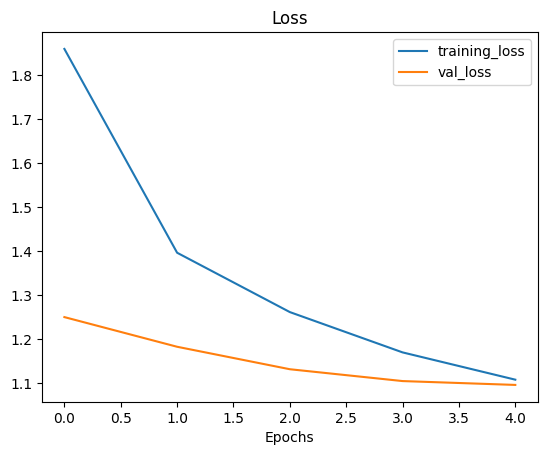

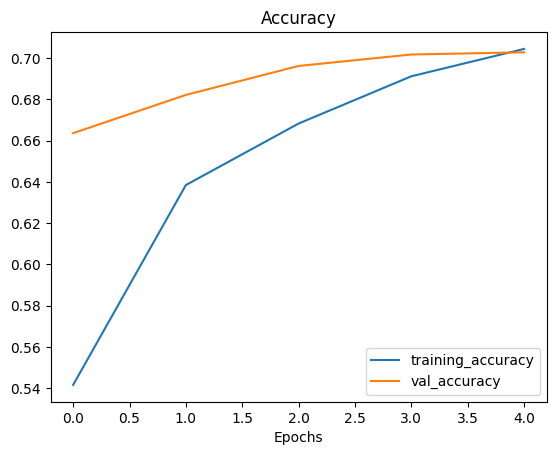

In [ ]:
plot_loss_curves(history_food101_feature_extract)

In [ ]:
print("Evaluating model performance on test data...")
feature_extract_model = model.evaluate(test_data)

print("\nEvaluation Complete!")
print("\nResults:\n")
print(f"Test Loss: {feature_extract_model[0]:.4f}")
print(f"Test Accuracy: {feature_extract_model[1]*100:.2f}%")
print("----------------------------------------------------")

Evaluating model performance on test data...
790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - accuracy: 0.7040 - loss: 1.0877

Evaluation Complete!

Results:

Test Loss: 1.0877
Test Accuracy: 70.29%
----------------------------------------------------


### **Fine-Tuning**

In [ ]:
wandb.init(
    project="Food Vision 101",
    name="EfficientNetB4_fine_tune",
    group="Fine-Tuning Experiments",
    notes="Fine-tuning EfficientNetB4 on Food101 dataset, unfreezing last 10 layers.",
    tags=["EfficientNetB4", "fine-tuning", "food-classification"],

    config={
        # Model Parameters
        "architecture": "EfficientNetB4",
        "input_shape": (224, 224, 3),
        "num_classes": 101,  # Food101 dataset has 101 classes

        # Training Parameters
        "epochs": 10,  # You can adjust epochs as required
        "batch_size": 32,
        "learning_rate": 0.0001,
        "optimizer": "Adam",
        "loss_function": "sparse_categorical_crossentropy",
        "metrics": ["accuracy"],

        # Dataset Details
        "dataset": "TensorFlow Food101",
        "train_size": len(train_data),
        "val_size": len(test_data),
        "validation_split": 0.15,

        # Fine-Tuning Configuration
        "fine_tuning_layers": 10,
        "freeze_layers": len(base_model.layers) - 10,

        # Model Checkpointing
        "checkpoint_monitor": "val_accuracy",
        "checkpoint_mode": "max",
        "save_best_only": True,

        # Experiment Tracking
        "run_type": "fine-tuning",
        "experiment_notes": "Fine-tuning EfficientNetB4 on Food101 dataset, unfreezing the last 10 layers.",
    }
)

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=["accuracy"])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 7, 7, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         181,093 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_2 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,854,916 (68.11 MB)

 Trainable params: 2,797,525 (10.67 MB)

 Non-trainable params: 15,057,391 (57.44 MB)

In [ ]:
fine_tune_epochs = 10

history_food101_fine_tuned = model.fit(train_data,
                                       epochs=fine_tune_epochs,
                                       validation_data=test_data,
                                       validation_steps=int(0.15 * len(test_data)),
                                       initial_epoch=history_food101_feature_extract.epoch[-1], # start from previous last epoch
                                       callbacks=[WandbMetricsLogger()])

wandb.finish()

Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 268s 91ms/step - accuracy: 0.7034 - loss: 1.1039 - val_accuracy: 0.7288 - val_loss: 0.9940
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 194s 81ms/step - accuracy: 0.7647 - loss: 0.8701 - val_accuracy: 0.7346 - val_loss: 0.9908
Epoch 7/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 186s 75ms/step - accuracy: 0.7979 - loss: 0.7448 - val_accuracy: 0.7447 - val_loss: 0.9637
Epoch 8/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 177s 73ms/step - accuracy: 0.8253 - loss: 0.6432 - val_accuracy: 0.7479 - val_loss: 0.9532
Epoch 9/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 201s 84ms/step - accuracy: 0.8518 - loss: 0.5563 - val_accuracy: 0.7458 - val_loss: 0.9605
Epoch 10/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 189s 79ms/step - accuracy: 0.8740 - loss: 0.4790 - val_accuracy: 0.7442 - val_loss: 0.9696


epoch/accuracy,▁▃▅▆▇█
epoch/epoch,▁▂▄▅▇█
epoch/learning_rate,▁▁▁▁▁▁
epoch/loss,█▆▄▃▂▁
epoch/val_accuracy,▁▃▇█▇▇
epoch/val_loss,█▇▃▁▂▄
epoch/accuracy,0.86881
epoch/epoch,9
epoch/learning_rate,0.0001
epoch/loss,0.49157
epoch/val_accuracy,0.74417


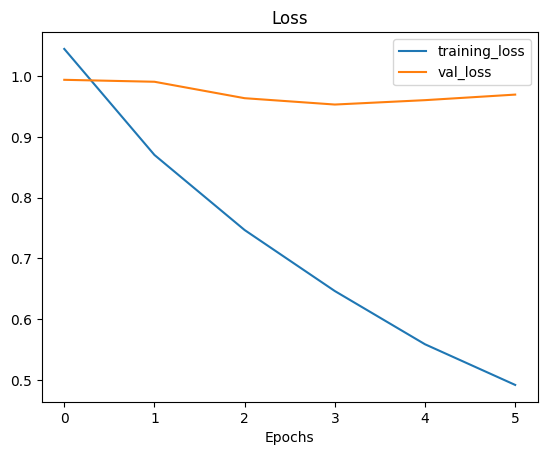

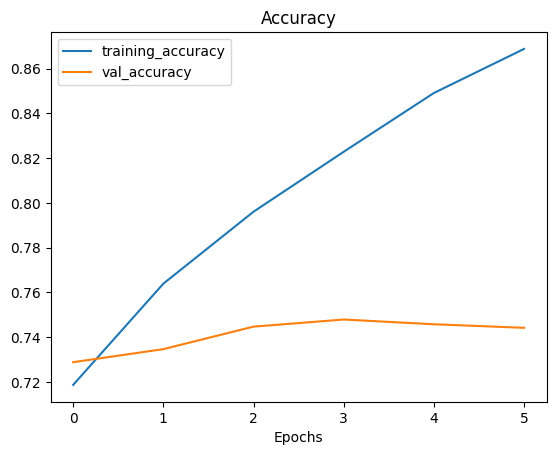

In [ ]:
plot_loss_curves(history_food101_fine_tuned)

In [ ]:
print("🔄 Evaluating model performance on test data...")
fine_tuned_model = model.evaluate(test_data)

print("\n✅ Evaluation Complete!")
print("\n📝 Results:\n")
print(f"Test Loss: {fine_tuned_model[0]:.4f}")
print(f"Test Accuracy: {fine_tuned_model[1]*100:.2f}%")
print("----------------------------------------------------")

🔄 Evaluating model performance on test data...
790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.7425 - loss: 0.9613

✅ Evaluation Complete!

📝 Results:

Test Loss: 0.9583
Test Accuracy: 74.28%
----------------------------------------------------


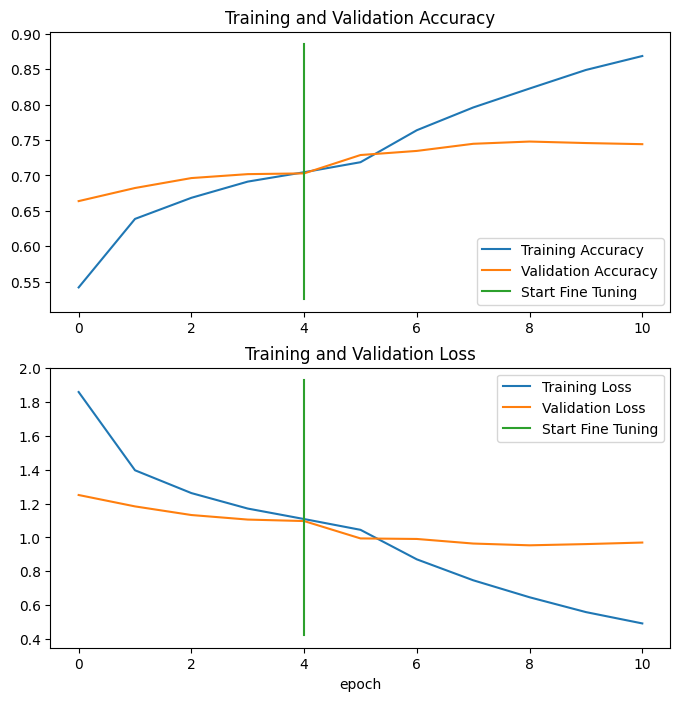

In [ ]:
compare_historys(original_history=history_food101_feature_extract,
                 new_history=history_food101_fine_tuned,
                 initial_epochs=5)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save("drive/My Drive/Models/Food Vision 101/101_food_class_fine_tuned_model.keras")

### **Evaluating the performance of the model across all different classes**

In [14]:
model_path = '/content/drive/My Drive/Models/Food Vision 101/101_food_class_fine_tuned_model.keras'
model = load_model(model_path, compile=False)

In [9]:
model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("🔄 Evaluating model performance on test data...")
loaded_loss, loaded_accuracy = model.evaluate(test_data)

print("\n✅ Evaluation Complete!")
print("\n📝 Results:\n")
print(f"Test Loss: {loaded_loss:.4f}")
print(f"Test Accuracy: {loaded_accuracy*100:.2f}%")
print("----------------------------------------------------")

🔄 Evaluating model performance on test data...
790/790 ━━━━━━━━━━━━━━━━━━━━ 86s 75ms/step - accuracy: 0.7428 - loss: 0.9605

✅ Evaluation Complete!

📝 Results:

Test Loss: 0.9583
Test Accuracy: 74.28%
----------------------------------------------------


In [12]:
print("Starting prediction...")
pred_probs = model.predict(test_data, verbose=1)
print("Prediction completed!")

print(f"Shape of predictions: {pred_probs.shape}")
print(f"First 5 predictions:\n{pred_probs[:5]}")
print(f"Prediction range: Min={np.min(pred_probs)}, Max={np.max(pred_probs)}")

Starting prediction...
790/790 ━━━━━━━━━━━━━━━━━━━━ 87s 87ms/step
Prediction completed!
Shape of predictions: (25250, 101)
First 5 predictions:
[[1.26366274e-06 8.47554986e-07 1.93439723e-06 2.96737981e-05
  1.01241119e-06 8.27476561e-06 1.71185235e-07 6.98438427e-08
  5.95432473e-04 3.60281945e-07 5.50602781e-05 1.15153028e-07
  2.33070296e-07 2.62165326e-04 1.58724759e-03 3.96406747e-08
  1.90368481e-02 7.21910309e-09 8.14535906e-06 2.43778970e-07
  5.80244432e-07 1.10791196e-04 5.25388859e-05 2.87803374e-07
  3.83518170e-07 4.43653562e-06 2.11798849e-07 2.00489067e-05
  1.27376406e-05 1.00174339e-05 4.01003399e-06 1.12485516e-07
  1.10276921e-09 2.27227005e-07 6.26263136e-06 3.87907448e-06
  2.44328512e-05 1.68391898e-06 1.20208867e-07 9.56661324e-07
  6.74411297e-07 3.72500858e-06 1.53645269e-05 1.22000904e-06
  3.09930179e-08 3.89557727e-07 3.26123967e-07 4.28681915e-07
  3.63107716e-07 1.50187873e-07 4.32044089e-07 4.87588601e-08
  3.21586549e-06 6.24947859e-07 6.63658184e-10 7.2

In [11]:
print(f"Total number of samples predicted: {len(pred_probs)}")
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"Prediction probabilities for sample 0:\n{pred_probs[0]}")
print(f"Class with the highest predicted probability for sample 0: {np.argmax(pred_probs[0])}")

Total number of samples predicted: 25250
Number of prediction probabilities for sample 0: 101
Prediction probabilities for sample 0:
[2.9678961e-02 1.2883736e-02 2.4988460e-03 3.3582797e-05 1.3297217e-03
 7.0139871e-04 7.6240483e-03 7.7614577e-06 4.7466094e-03 2.4621410e-04
 7.1405008e-02 4.8380607e-06 1.5994972e-02 5.4199889e-04 3.4896915e-03
 1.2814722e-02 2.8561335e-04 5.6139246e-04 2.5806867e-03 7.4866316e-03
 8.4746676e-03 1.4875419e-04 2.2796732e-03 2.5853459e-04 4.4156942e-03
 8.1192797e-05 4.6965942e-02 5.6460725e-05 6.8783242e-04 1.3675097e-05
 3.4760865e-03 2.5832080e-03 3.9318234e-02 8.2943652e-06 5.3011902e-02
 1.3232447e-03 1.0344230e-04 7.7184173e-04 7.9311962e-05 6.0938572e-04
 4.5723285e-05 6.6019129e-04 1.6185930e-01 6.7981891e-04 6.1287530e-05
 2.0528752e-05 3.1373173e-03 5.9725079e-03 2.5152354e-05 1.1677593e-03
 1.7121503e-04 2.4188783e-05 1.5780132e-01 4.1522137e-03 6.2496321e-05
 1.5992582e-03 1.2138660e-02 1.3386428e-04 1.6176267e-05 2.5107025e-04
 7.8082347e-05 

In [13]:
pred_classes = np.argmax(pred_probs, axis=1) # Get the class predicitons of each label

if len(pred_classes) > 0:
    print(f"Total predictions made: {len(pred_classes)}")
    print(f"First 10 class predictions: {pred_classes[:10]}")
else:
    print("No class predictions were generated. Please check the model output.")

Total predictions made: 25250
First 10 class predictions: [83 80 45 34 23 30 72 45  6 92]


In [14]:
y_labels = []
print("Extracting true labels from test data...")

for _, labels in test_data.unbatch():  # Unbatch the test dataset
    y_labels.append(labels.numpy())  # Append class index directly

y_labels = np.array(y_labels)  # Convert list to NumPy array

print(f"Total labels extracted: {len(y_labels)}")
print(f"Shape of y_labels: {y_labels.shape}")
print(f"First 10 true labels: {y_labels[:10]}")

Extracting true labels from test data...
Total labels extracted: 25250
Shape of y_labels: (25250,)
First 10 true labels: [ 29  81  91  53  97  97  10  31   3 100]


In [5]:
for sample in test_data.take(1):
    print(sample)


(<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 43,  39,  40],
        [ 42,  38,  39],
        [ 41,  36,  40],
        ...,
        [133,  59,  46],
        [130,  58,  46],
        [129,  57,  45]],

       [[ 41,  36,  40],
        [ 44,  39,  43],
        [ 45,  40,  44],
        ...,
        [132,  58,  45],
        [127,  55,  43],
        [124,  52,  40]],

       [[ 40,  38,  43],
        [ 46,  44,  49],
        [ 48,  46,  51],
        ...,
        [133,  60,  45],
        [127,  55,  41],
        [122,  50,  36]],

       ...,

       [[232, 231, 227],
        [231, 230, 226],
        [230, 229, 225],
        ...,
        [228, 223, 217],
        [227, 222, 216],
        [226, 223, 214]],

       [[232, 231, 227],
        [231, 230, 226],
        [230, 229, 225],
        ...,
        [226, 223, 218],
        [226, 223, 218],
        [224, 224, 216]],

       [[232, 231, 227],
        [231, 230, 226],
        [230, 229, 225],
        ...,
        [226, 223, 2

### **Evaluating our models predictions**

### **"Most Confused" Classes**

In [21]:
cm = confusion_matrix(y_labels, pred_classes)
n_classes = cm.shape[0]

# Find the most confused pairs (off-diagonal)
confused_pairs = []
for i in range(n_classes):
    for j in range(n_classes):
        if i != j:
            confused_pairs.append((i, j, cm[i, j]))

# Sort by highest confusion
confused_pairs_sorted = sorted(confused_pairs, key=lambda x: x[2], reverse=True)[:10]  # Top 10

# Print the top confused classes
for (i, j, count) in confused_pairs_sorted:
    print(f"Class {class_names[i]} often misclassified as {class_names[j]}: {count} times")

Class cannoli often misclassified as baklava: 12 times
Class cannoli often misclassified as shrimp_and_grits: 9 times
Class chocolate_cake often misclassified as cheesecake: 9 times
Class strawberry_shortcake often misclassified as bibimbap: 9 times
Class tiramisu often misclassified as scallops: 9 times
Class tuna_tartare often misclassified as beignets: 9 times
Class apple_pie often misclassified as pulled_pork_sandwich: 8 times
Class apple_pie often misclassified as shrimp_and_grits: 8 times
Class baklava often misclassified as chicken_wings: 8 times
Class beef_carpaccio often misclassified as caprese_salad: 8 times


### **Visualize Subsets of Classes**

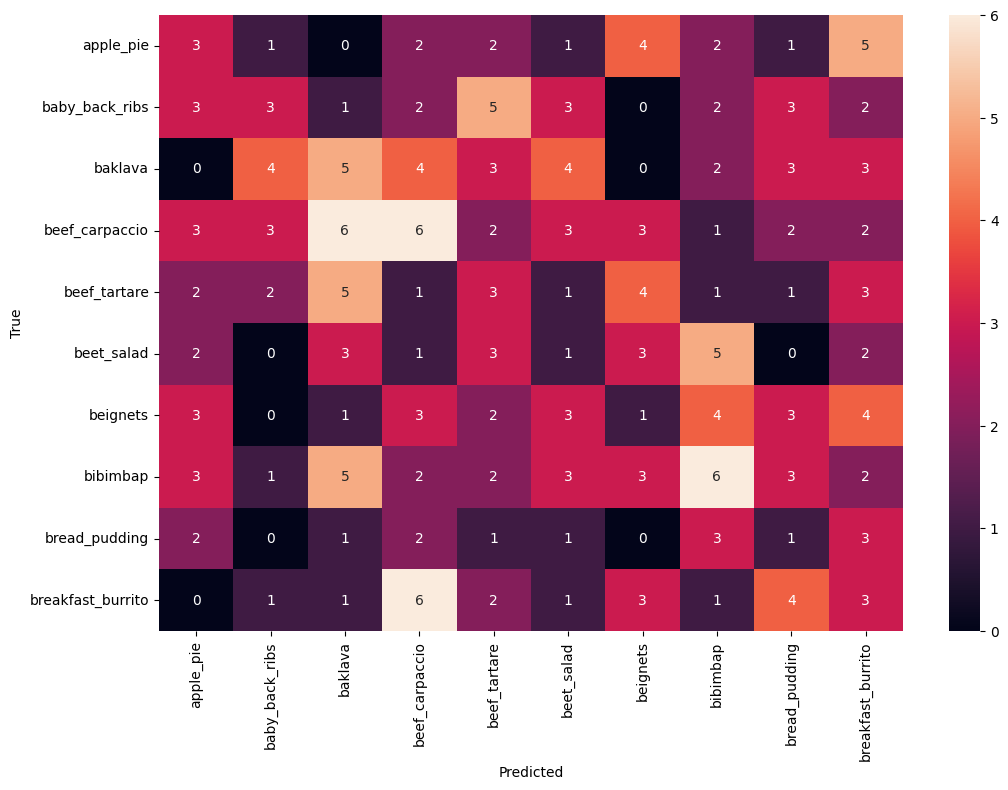

In [22]:
subset_classes = class_names[:10]
subset_cm = cm[:10, :10]

plt.figure(figsize=(12, 8))
sns.heatmap(subset_cm, annot=True, fmt="d", xticklabels=subset_classes, yticklabels=subset_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [23]:
fig = px.imshow(cm, x=class_names, y=class_names, color_continuous_scale='Viridis')
fig.update_layout(width=1000, height=1000)
fig.show()

### **Visualizing predictions on test images**

### **Testing out the model on custom images of food**

In [9]:
class_names = ds_info.features["label"].names

print("\nFood-101 Class Names:\n" + "-" * 40)
for i, name in enumerate(class_names, start=1):
    print(f"{i:3}. {name}")
print("-" * 40)


Food-101 Class Names:
----------------------------------------
  1. apple_pie
  2. baby_back_ribs
  3. baklava
  4. beef_carpaccio
  5. beef_tartare
  6. beet_salad
  7. beignets
  8. bibimbap
  9. bread_pudding
 10. breakfast_burrito
 11. bruschetta
 12. caesar_salad
 13. cannoli
 14. caprese_salad
 15. carrot_cake
 16. ceviche
 17. cheesecake
 18. cheese_plate
 19. chicken_curry
 20. chicken_quesadilla
 21. chicken_wings
 22. chocolate_cake
 23. chocolate_mousse
 24. churros
 25. clam_chowder
 26. club_sandwich
 27. crab_cakes
 28. creme_brulee
 29. croque_madame
 30. cup_cakes
 31. deviled_eggs
 32. donuts
 33. dumplings
 34. edamame
 35. eggs_benedict
 36. escargots
 37. falafel
 38. filet_mignon
 39. fish_and_chips
 40. foie_gras
 41. french_fries
 42. french_onion_soup
 43. french_toast
 44. fried_calamari
 45. fried_rice
 46. frozen_yogurt
 47. garlic_bread
 48. gnocchi
 49. greek_salad
 50. grilled_cheese_sandwich
 51. grilled_salmon
 52. guacamole
 53. gyoza
 54. hamburger
 5

In [49]:
def load_and_prep_image(filename, img_shape=224):
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  # img = img/255.
  return img

def pred_and_plot(model, filename, class_names):
  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  print("Index of maximum predicted value:", pred.argmax())

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # pred_class = class_names[tf.argmax(pred, axis=1).numpy()[0]]

  plt.imshow(img/255.)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  plt.show()

In [27]:
!wget -q https://hips.hearstapps.com/hmg-prod/images/breakfast-burrito-lead-66a7e23ce81b0.jpg
!wget -q https://i2.wp.com/www.downshiftology.com/wp-content/uploads/2015/08/Roasted-Beet-Salad-11.jpg
!wget -q https://images.squarespace-cdn.com/content/v1/5ba3eeed755be24d0ec5e917/1621084089585-HVZO0G3WKUZGETIMJPCH/apple_pie.jpg
!wget -q https://img.freepik.com/premium-photo/ice-cream_919128-80.jpg
!wget -q https://www.lifeloveandsugar.com/wp-content/uploads/2024/10/Cannoli-Recipe3-1025x1536.jpg
!wget -q https://kitchenofdebjani.com/wp-content/uploads/2023/04/easy-indian-chicken-curry-Recipe-for-beginners-Debjanir-rannaghar-1024x1024.jpg

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Index of maximum predicted value: 9


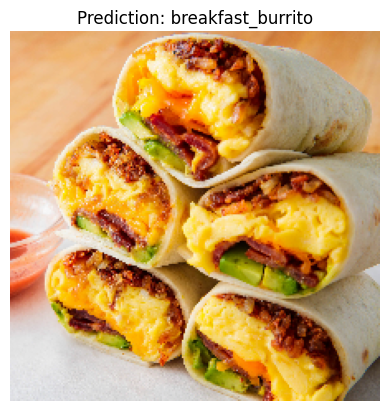

In [50]:
pred_and_plot(model=model,
              filename="breakfast-burrito-lead-66a7e23ce81b0.jpg",
              class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Index of maximum predicted value: 5


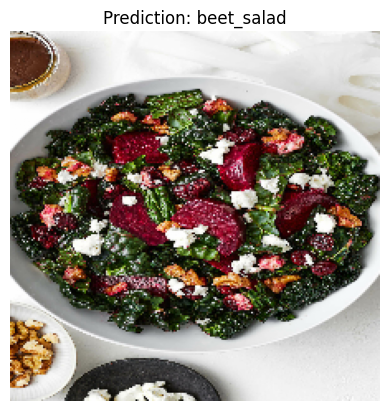

In [51]:
pred_and_plot(model=model,
              filename="Roasted-Beet-Salad-11.jpg",
              class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Index of maximum predicted value: 0


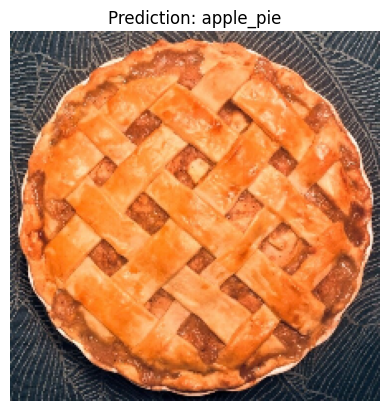

In [52]:
pred_and_plot(model=model,
              filename="apple_pie.jpg",
              class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Index of maximum predicted value: 58


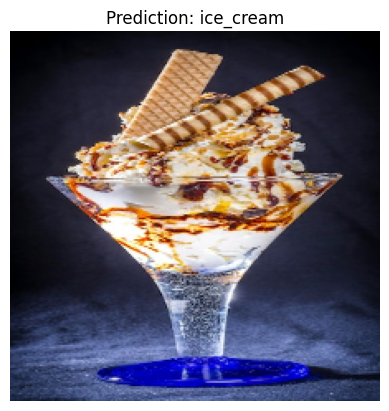

In [53]:
pred_and_plot(model=model,
              filename="ice-cream_919128-80.jpg",
              class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Index of maximum predicted value: 12


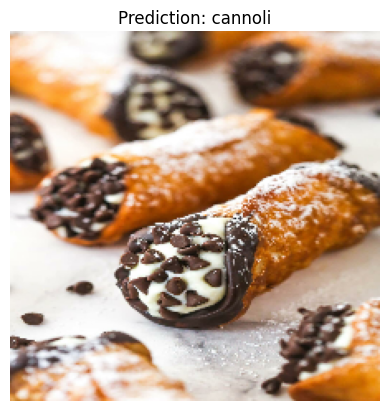

In [54]:
pred_and_plot(model=model,
              filename="Cannoli-Recipe3-1025x1536.jpg",
              class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Index of maximum predicted value: 18


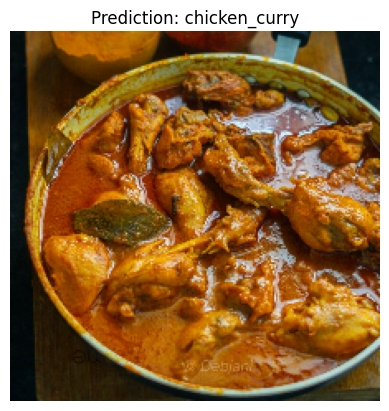

In [55]:
pred_and_plot(model=model,
              filename="easy-indian-chicken-curry-Recipe-for-beginners-Debjanir-rannaghar-1024x1024.jpg",
              class_names=class_names)